In [2]:
import os
import cv2
import pandas
import numpy as np
import matplotlib.pyplot as plt

def clipped(im):
    h, w, _ = im.shape
    nh, nw = (h-66)//2, (w-200)//2
    im = im[nh:nh+66, nw:nw+200, :]
    return im

def extract_image(f):
    im = cv2.imread(f)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2YUV)
    #im = clipped(im)
    im = im[:,:,0:1]
    return im

def process_db(dir):
    with open(os.path.join(dir, 'driving_log.csv'), 'r') as f:
        data = pandas.read_csv(f, header=0, skipinitialspace=True)
        res = np.asarray(data.values)
        c, l, r, st, t, b, sp = np.split(res, 7, axis=1)
        l = np.array([extract_image(os.path.join(dir, p)) for p in l.squeeze()])
        c = np.array([extract_image(os.path.join(dir, p)) for p in c.squeeze()])
        r = np.array([extract_image(os.path.join(dir, p)) for p in r.squeeze()])        
        return l, c, r, st.squeeze()
        
l, c, r, st = process_db('../data')
print(c.shape)

(8036, 160, 320, 1)


4881 3155
(24930, 160, 320, 1) (24930,)
52 52


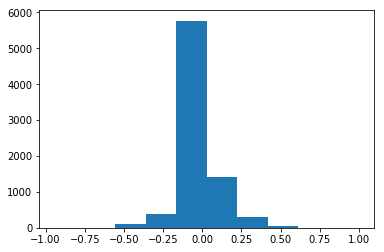

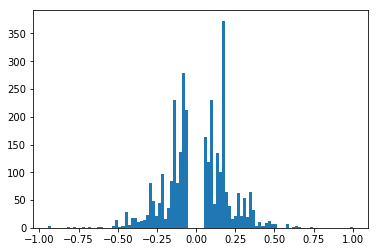

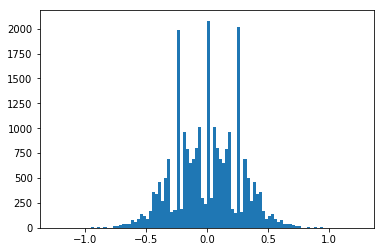

In [53]:
limit = 0.05
extreme = np.logical_or(st<-limit, st>limit)
normal = np.logical_and(st>=-limit, st<=limit)

nb_normal = 1000

print(len(st[normal]), len(st[extreme]))

bal_st = np.append(st[normal][:nb_normal], st[extreme])
bal_c = np.append(c[normal][:nb_normal], c[extreme], axis=0)
bal_l = np.append(l[normal][:nb_normal], l[extreme], axis=0)
bal_r = np.append(r[normal][:nb_normal], r[extreme], axis=0)

features = np.append(bal_c, bal_l, axis=0)
features = np.append(features, bal_r, axis=0)

labels = np.append(bal_st, bal_st+0.25, axis=0)
labels = np.append(labels, bal_st-0.25, axis=0)

features = np.append(features, np.fliplr(features), axis=0)
labels = np.append(labels, -labels)

print(features.shape, labels.shape)
print(len(labels[labels>0.75]), len(labels[labels<-0.75]))

%matplotlib inline
_ = plt.hist(st, 10)
plt.figure()
_ = plt.hist(st[extreme], 100)
plt.figure()
_ = plt.hist(labels, 100)



In [25]:

labels = labels.astype(np.float32)
features = features.astype(np.float32)

mn = np.min(features, axis=(1,2,3), keepdims=True)
mx = np.max(features, axis=(1,2,3), keepdims=True)
rng = (mx - mn)
features -= mn
features = features/rng

X_train, y_train = features, labels
print(X_train.shape, y_train.shape)



(24678, 160, 320, 1) (24678,)


In [26]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.wrappers.scikit_learn import KerasRegressor

from keras.layers.pooling import MaxPooling2D
import numpy as np
from random import random

def my_model():
    model = Sequential()
    model.add(Convolution2D(16, 5, 5, border_mode='same', activation='relu', name='c1', input_shape=(160, 320, 1)))
    model.add(MaxPooling2D((2,2)))
    model.add(Convolution2D(32, 5, 5, border_mode='same', activation='relu', name='c2'))
    model.add(MaxPooling2D((2,2)))
    model.add(Convolution2D(64, 5, 5, border_mode='same', activation='relu', name='c3'))
    model.add(MaxPooling2D((2,2)))

    model.add(Flatten())
    model.add(Dense(64, name='d1'))
    model.add(Dense(32, name='d2'))
    model.add(Dense(16, name='d3'))
    model.add(Dense(1, name='d4'))
    
    return model

def nvidia_model():
    model = Sequential()
    model.add(Convolution2D(24, 5, 5, border_mode='same', activation='relu', name='c1', subsample=(2,2), input_shape=(160, 320, 1)))
    model.add(Convolution2D(36, 5, 5, border_mode='same', activation='relu', name='c2', subsample=(2,2)))
    model.add(Convolution2D(48, 5, 5, border_mode='same', activation='relu', name='c3', subsample=(2,2)))
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu', name='c4'))
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu', name='c5'))
    model.add(Flatten())
    model.add(Dense(1164, name='d1'))
    model.add(Dense(100, name='d2'))
    model.add(Dense(50, name='d3'))
    model.add(Dense(10, name='d4'))
    model.add(Dense(1, name='out'))

    return model


model = my_model()
model.compile('adam', 'mse', ['mse'])
history = model.fit(X_train, y_train, batch_size=32, nb_epoch=5, verbose=2, validation_split=0.2)
y_pred = model.predict(X_train)

print(np.column_stack((y_train, y_pred.squeeze())))
print(model.save("model.balanced.h5"))


Train on 19742 samples, validate on 4936 samples
Epoch 1/5
1370s - loss: 0.3202 - mean_squared_error: 0.3202 - val_loss: 0.0594 - val_mean_squared_error: 0.0594
Epoch 2/5


KeyboardInterrupt: 

In [4]:
# balancing data
# different network model
# regularization
# all colour channels

# normalization it's own layer
